In [1]:
# 10분 뒤 최대 전압 예측 - 결과.ipynb 참조

import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np


sel_features = ['hour','RACK_VOLTAGE','RACK_MIN_CELL_VOLTAGE','RACK_MIN_CELL_TEMPERATURE',
                'RACK_MAX_CELL_TEMPERATURE','RACK_CURRENT','minute','RACK_CELL_TEMPERATURE_GAP',
                'RACK_MAX_CELL_VOLTAGE','RACK_CELL_VOLTAGE_AVERAGE','RACK_CELL_VOLTAGE_GAP','day',
                'RACK_SOC','RACK_CELL_TEMPERATURE_AVERAGE']

label = "RACK_MAX_CELL_TEMPERATURE"

def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

train_dates = date_range("20211001", "20220430")

path = "./forecasting_data/"

train = pd.DataFrame()

for train_date in train_dates:
    try:
        ess_data = pd.read_feather(path + train_date + "/rack.feather")[sel_features]

        train = pd.concat([train, ess_data], axis=0)
    except:
        pass

trainX = train.iloc[:-600,:]
trainY = train.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

In [2]:
from datetime import datetime
import numpy as np



def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

valid_dates = date_range("20220501", "20220630")

path = "./forecasting_data/"

valid = pd.DataFrame()

for valid_date in valid_dates:
    try:
        ess_data = pd.read_feather(path + valid_date + "/rack.feather")[sel_features]
        valid = pd.concat([valid, ess_data], axis=0)
    except:
        pass

validX = valid.iloc[:-600,:]
validY = valid.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

In [3]:
lightGBM_param = {"learning_rate"                    : 0.05, 
                  "num_leaves"                       : 255,
                  "colsample_bytree"                 : 0.8466655445017455,
                  "subsample"                        : 0.8363223383173761,
                  "verbosity"                        : -1,
                  "random_state"                     : 42,
                  "objective"                        : "regression",
                  "metric"                           : "l2",
                  "num_threads"                      : 10,
                  "min_sum_hessian_in_leaf"          : 0.3139754544772033,
                  "reg_alpha"                        : 1.3918976712256577e-07,
                  "reg_lambda"                       : 0.015222751757854997,
                  "n_estimators"                     : 1000,
                  "max_depth "                       : 10
                 }

XGBoost_param = {"max_depth" : 4,
                 "learning_rate": 0.10261711125039377,
                 "n_estimators": 2000,
                 "colsample_bytree": 0.8306482536182962,
                 "colsample_bylevel": 0.5200894204312736,
                 "colsample_bynode": 0.9125155627018552,
                 "reg_lambda": 0.29449215771684206,
                 "reg_alpha": 0.019867959415002325,
                 "subsample": 0.85,
                 "min_child_weight": 9,
                 "gamma" : 0.1010776765952064,
                 "tree_method" : 'gpu_hist', 
                 "gpu_id" : 0
                }

#trainX = train.iloc[:-600,:].drop(["TIMESTAMP","BANK_ID","RACK_ID"], axis=1)
#trainY = train.reset_index(drop=True).loc[600:,"RACK_MAX_CELL_VOLTAGE"].reset_index(drop=True)

trainX, trainY = trainX.apply(pd.to_numeric), trainY.apply(pd.to_numeric)
validX, validY = validX.apply(pd.to_numeric), validY.apply(pd.to_numeric)

In [4]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(**lightGBM_param)
lgb_model.fit(trainX, trainY)

[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.3139754544772033, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.3139754544772033
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10


LGBMRegressor(colsample_bytree=0.8466655445017455, learning_rate=0.05,
              max_depth =10, metric='l2',
              min_sum_hessian_in_leaf=0.3139754544772033, n_estimators=1000,
              num_leaves=255, num_threads=10, objective='regression',
              random_state=42, reg_alpha=1.3918976712256577e-07,
              reg_lambda=0.015222751757854997, subsample=0.8363223383173761,
              verbosity=-1)

In [5]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(**XGBoost_param)
xgb_model.fit(trainX,trainY)

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.5200894204312736,
             colsample_bynode=0.9125155627018552,
             colsample_bytree=0.8306482536182962, enable_categorical=False,
             gamma=0.1010776765952064, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.10261711125039377,
             max_delta_step=0, max_depth=4, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.019867959415002325, reg_lambda=0.29449215771684206,
             scale_pos_weight=1, subsample=0.85, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [6]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression().fit(trainX, trainY)

In [7]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(task_type="GPU", devices='0:1').fit(trainX, trainY)

Learning rate set to 0.144712
0:	learn: 3.0975891	total: 74.4ms	remaining: 1m 14s
1:	learn: 2.6725478	total: 153ms	remaining: 1m 16s
2:	learn: 2.3073062	total: 229ms	remaining: 1m 16s
3:	learn: 1.9935277	total: 320ms	remaining: 1m 19s
4:	learn: 1.7207434	total: 395ms	remaining: 1m 18s
5:	learn: 1.4875313	total: 469ms	remaining: 1m 17s
6:	learn: 1.2876528	total: 553ms	remaining: 1m 18s
7:	learn: 1.1171598	total: 628ms	remaining: 1m 17s
8:	learn: 0.9682309	total: 704ms	remaining: 1m 17s
9:	learn: 0.8423558	total: 783ms	remaining: 1m 17s
10:	learn: 0.7342022	total: 858ms	remaining: 1m 17s
11:	learn: 0.6424606	total: 932ms	remaining: 1m 16s
12:	learn: 0.5637895	total: 1.01s	remaining: 1m 16s
13:	learn: 0.4965437	total: 1.08s	remaining: 1m 16s
14:	learn: 0.4406433	total: 1.16s	remaining: 1m 15s
15:	learn: 0.3919318	total: 1.24s	remaining: 1m 16s
16:	learn: 0.3503169	total: 1.31s	remaining: 1m 15s
17:	learn: 0.3161202	total: 1.39s	remaining: 1m 15s
18:	learn: 0.2864123	total: 1.47s	remaining

159:	learn: 0.0873113	total: 12.4s	remaining: 1m 5s
160:	learn: 0.0871832	total: 12.5s	remaining: 1m 5s
161:	learn: 0.0870547	total: 12.6s	remaining: 1m 4s
162:	learn: 0.0869805	total: 12.6s	remaining: 1m 4s
163:	learn: 0.0868846	total: 12.7s	remaining: 1m 4s
164:	learn: 0.0868268	total: 12.8s	remaining: 1m 4s
165:	learn: 0.0865315	total: 12.9s	remaining: 1m 4s
166:	learn: 0.0858924	total: 12.9s	remaining: 1m 4s
167:	learn: 0.0857962	total: 13s	remaining: 1m 4s
168:	learn: 0.0857274	total: 13.1s	remaining: 1m 4s
169:	learn: 0.0856672	total: 13.2s	remaining: 1m 4s
170:	learn: 0.0856193	total: 13.2s	remaining: 1m 4s
171:	learn: 0.0855465	total: 13.3s	remaining: 1m 4s
172:	learn: 0.0854881	total: 13.4s	remaining: 1m 4s
173:	learn: 0.0854290	total: 13.5s	remaining: 1m 4s
174:	learn: 0.0853866	total: 13.6s	remaining: 1m 3s
175:	learn: 0.0837569	total: 13.6s	remaining: 1m 3s
176:	learn: 0.0836699	total: 13.7s	remaining: 1m 3s
177:	learn: 0.0836066	total: 13.8s	remaining: 1m 3s
178:	learn: 0.

321:	learn: 0.0697296	total: 25s	remaining: 52.7s
322:	learn: 0.0696983	total: 25.1s	remaining: 52.6s
323:	learn: 0.0696707	total: 25.2s	remaining: 52.5s
324:	learn: 0.0696293	total: 25.3s	remaining: 52.5s
325:	learn: 0.0695723	total: 25.4s	remaining: 52.4s
326:	learn: 0.0695315	total: 25.4s	remaining: 52.3s
327:	learn: 0.0695007	total: 25.5s	remaining: 52.3s
328:	learn: 0.0694604	total: 25.6s	remaining: 52.2s
329:	learn: 0.0694261	total: 25.7s	remaining: 52.1s
330:	learn: 0.0694027	total: 25.7s	remaining: 52s
331:	learn: 0.0693621	total: 25.8s	remaining: 51.9s
332:	learn: 0.0693362	total: 25.9s	remaining: 51.8s
333:	learn: 0.0693021	total: 26s	remaining: 51.8s
334:	learn: 0.0691661	total: 26s	remaining: 51.7s
335:	learn: 0.0691253	total: 26.1s	remaining: 51.6s
336:	learn: 0.0691017	total: 26.2s	remaining: 51.6s
337:	learn: 0.0690786	total: 26.3s	remaining: 51.5s
338:	learn: 0.0690522	total: 26.4s	remaining: 51.4s
339:	learn: 0.0689815	total: 26.4s	remaining: 51.3s
340:	learn: 0.068952

481:	learn: 0.0617346	total: 37.6s	remaining: 40.4s
482:	learn: 0.0617061	total: 37.7s	remaining: 40.3s
483:	learn: 0.0614336	total: 37.8s	remaining: 40.3s
484:	learn: 0.0614217	total: 37.8s	remaining: 40.2s
485:	learn: 0.0613496	total: 37.9s	remaining: 40.1s
486:	learn: 0.0612068	total: 38s	remaining: 40s
487:	learn: 0.0611910	total: 38.1s	remaining: 40s
488:	learn: 0.0611767	total: 38.2s	remaining: 39.9s
489:	learn: 0.0611576	total: 38.3s	remaining: 39.8s
490:	learn: 0.0610695	total: 38.3s	remaining: 39.7s
491:	learn: 0.0610604	total: 38.4s	remaining: 39.7s
492:	learn: 0.0609560	total: 38.5s	remaining: 39.6s
493:	learn: 0.0609437	total: 38.6s	remaining: 39.5s
494:	learn: 0.0609336	total: 38.6s	remaining: 39.4s
495:	learn: 0.0609200	total: 38.7s	remaining: 39.3s
496:	learn: 0.0608998	total: 38.8s	remaining: 39.3s
497:	learn: 0.0608290	total: 38.9s	remaining: 39.2s
498:	learn: 0.0608174	total: 38.9s	remaining: 39.1s
499:	learn: 0.0607928	total: 39s	remaining: 39s
500:	learn: 0.0607707	

640:	learn: 0.0572544	total: 50.1s	remaining: 28.1s
641:	learn: 0.0572459	total: 50.2s	remaining: 28s
642:	learn: 0.0572373	total: 50.3s	remaining: 27.9s
643:	learn: 0.0572187	total: 50.4s	remaining: 27.8s
644:	learn: 0.0572109	total: 50.4s	remaining: 27.8s
645:	learn: 0.0572000	total: 50.5s	remaining: 27.7s
646:	learn: 0.0571922	total: 50.6s	remaining: 27.6s
647:	learn: 0.0571818	total: 50.7s	remaining: 27.5s
648:	learn: 0.0571697	total: 50.8s	remaining: 27.5s
649:	learn: 0.0571622	total: 50.8s	remaining: 27.4s
650:	learn: 0.0571347	total: 50.9s	remaining: 27.3s
651:	learn: 0.0571288	total: 51s	remaining: 27.2s
652:	learn: 0.0571201	total: 51.1s	remaining: 27.1s
653:	learn: 0.0571070	total: 51.2s	remaining: 27.1s
654:	learn: 0.0570945	total: 51.2s	remaining: 27s
655:	learn: 0.0570819	total: 51.3s	remaining: 26.9s
656:	learn: 0.0570710	total: 51.4s	remaining: 26.8s
657:	learn: 0.0570557	total: 51.5s	remaining: 26.8s
658:	learn: 0.0570451	total: 51.6s	remaining: 26.7s
659:	learn: 0.0570

801:	learn: 0.0542605	total: 1m 3s	remaining: 15.6s
802:	learn: 0.0542552	total: 1m 3s	remaining: 15.5s
803:	learn: 0.0542476	total: 1m 3s	remaining: 15.4s
804:	learn: 0.0542441	total: 1m 3s	remaining: 15.3s
805:	learn: 0.0542393	total: 1m 3s	remaining: 15.3s
806:	learn: 0.0542332	total: 1m 3s	remaining: 15.2s
807:	learn: 0.0542251	total: 1m 3s	remaining: 15.1s
808:	learn: 0.0542148	total: 1m 3s	remaining: 15s
809:	learn: 0.0542076	total: 1m 3s	remaining: 14.9s
810:	learn: 0.0541988	total: 1m 3s	remaining: 14.9s
811:	learn: 0.0541904	total: 1m 3s	remaining: 14.8s
812:	learn: 0.0541798	total: 1m 3s	remaining: 14.7s
813:	learn: 0.0541722	total: 1m 4s	remaining: 14.6s
814:	learn: 0.0541643	total: 1m 4s	remaining: 14.5s
815:	learn: 0.0541553	total: 1m 4s	remaining: 14.5s
816:	learn: 0.0541433	total: 1m 4s	remaining: 14.4s
817:	learn: 0.0541305	total: 1m 4s	remaining: 14.3s
818:	learn: 0.0541182	total: 1m 4s	remaining: 14.2s
819:	learn: 0.0540802	total: 1m 4s	remaining: 14.2s
820:	learn: 0.

960:	learn: 0.0524950	total: 1m 15s	remaining: 3.07s
961:	learn: 0.0524885	total: 1m 15s	remaining: 2.99s
962:	learn: 0.0524845	total: 1m 15s	remaining: 2.91s
963:	learn: 0.0524767	total: 1m 15s	remaining: 2.83s
964:	learn: 0.0524059	total: 1m 15s	remaining: 2.76s
965:	learn: 0.0523987	total: 1m 16s	remaining: 2.68s
966:	learn: 0.0523898	total: 1m 16s	remaining: 2.6s
967:	learn: 0.0523830	total: 1m 16s	remaining: 2.52s
968:	learn: 0.0523689	total: 1m 16s	remaining: 2.44s
969:	learn: 0.0523517	total: 1m 16s	remaining: 2.36s
970:	learn: 0.0523475	total: 1m 16s	remaining: 2.28s
971:	learn: 0.0523412	total: 1m 16s	remaining: 2.21s
972:	learn: 0.0523337	total: 1m 16s	remaining: 2.13s
973:	learn: 0.0523295	total: 1m 16s	remaining: 2.05s
974:	learn: 0.0523240	total: 1m 16s	remaining: 1.97s
975:	learn: 0.0523163	total: 1m 16s	remaining: 1.89s
976:	learn: 0.0523086	total: 1m 16s	remaining: 1.81s
977:	learn: 0.0523010	total: 1m 17s	remaining: 1.73s
978:	learn: 0.0522959	total: 1m 17s	remaining: 

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

lgb_pred = lgb_model.predict(validX[sel_features])
xgb_pred = xgb_model.predict(validX[sel_features])
linear_pred = linear_reg.predict(validX[sel_features])
cat_pred = cat_model.predict(validX[sel_features])

print(f"LightGBM loss(MSE) : {mean_squared_error(validY,lgb_pred)}")
print(f"XGBoost loss(MSE)  : {mean_squared_error(validY,xgb_pred)}")
print(f"Linear loss(MSE)  : {mean_squared_error(validY,linear_pred)}")
print(f"CatBoost loss(MSE)  : {mean_squared_error(validY,cat_pred)}")
print()

print(f"LightGBM loss(MAE) : {mean_absolute_error(validY,lgb_pred)}")
print(f"XGBoost loss(MAE)  : {mean_absolute_error(validY,xgb_pred)}")
print(f"Linear loss(MAE)  : {mean_absolute_error(validY,linear_pred)}")
print(f"CatBoost loss(MAE)  : {mean_absolute_error(validY,cat_pred)}")

LightGBM loss(MSE) : 0.012655644533465743
XGBoost loss(MSE)  : 0.019861045556659445
Linear loss(MSE)  : 0.026046667230799625
CatBoost loss(MSE)  : 0.01431464828987269

LightGBM loss(MAE) : 0.04998423402610429
XGBoost loss(MAE)  : 0.07417684061655529
Linear loss(MAE)  : 0.10109492926538104
CatBoost loss(MAE)  : 0.05064907377867848


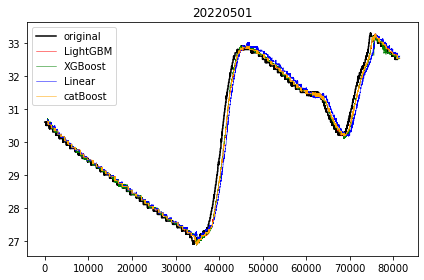

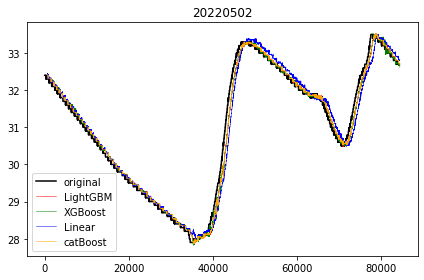

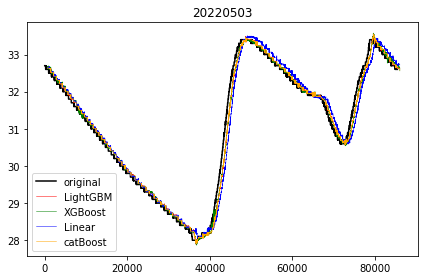

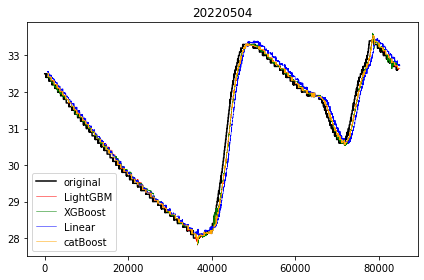

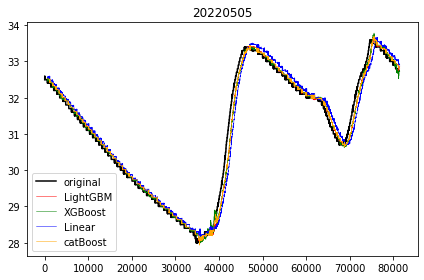

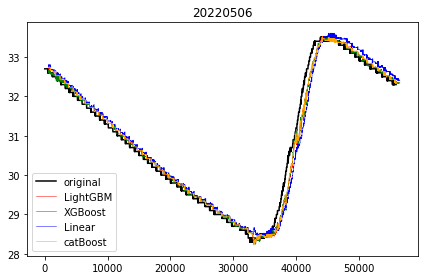

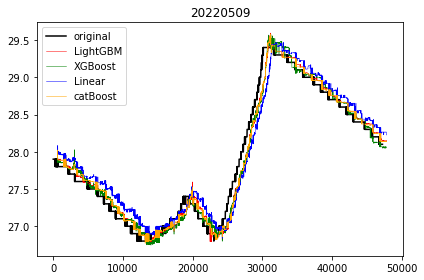

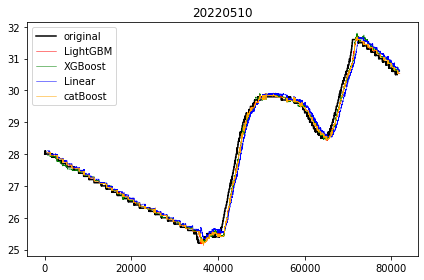

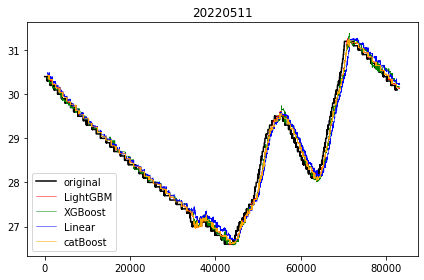

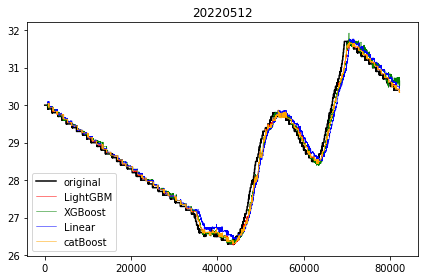

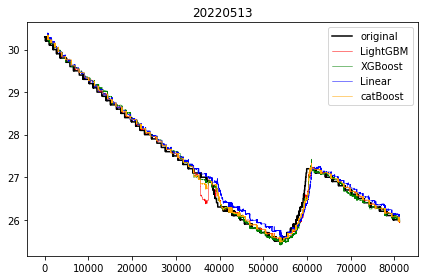

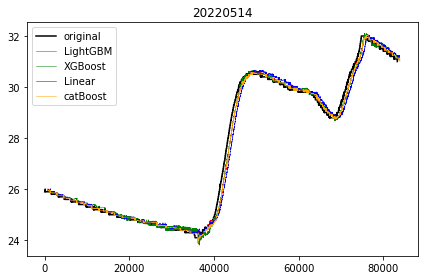

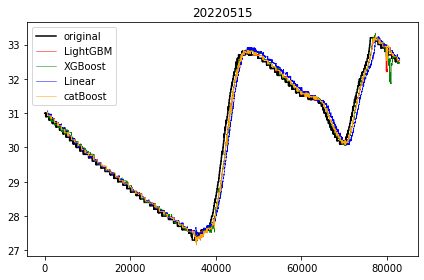

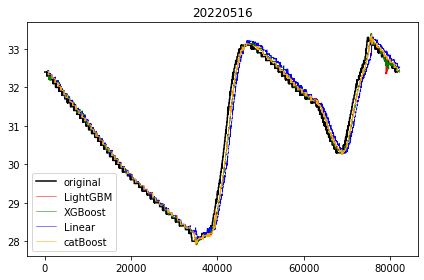

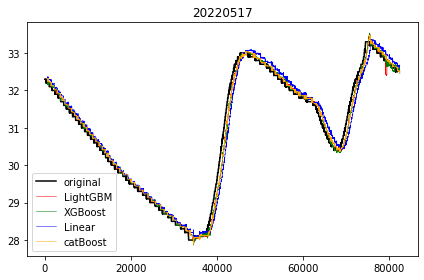

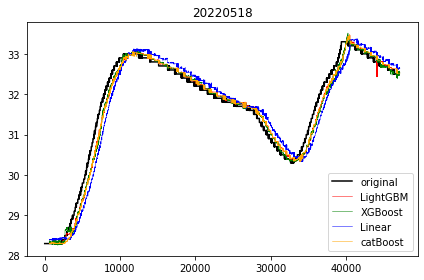

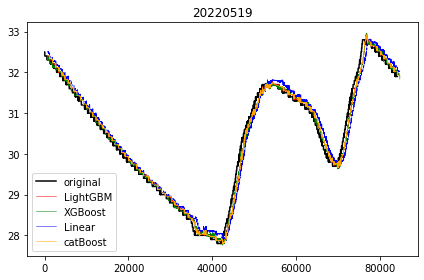

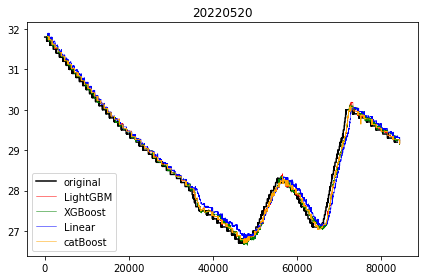

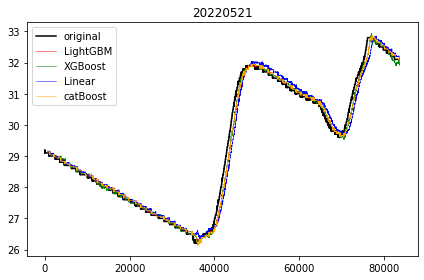

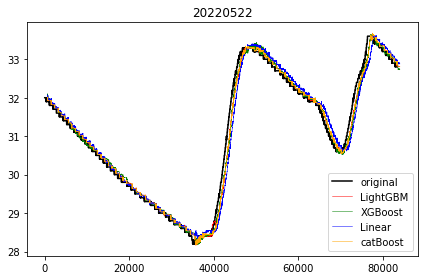

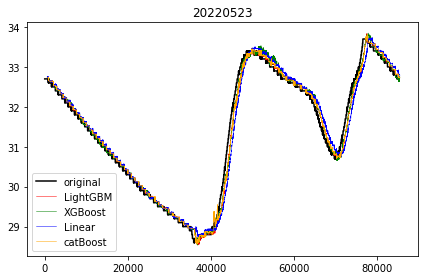

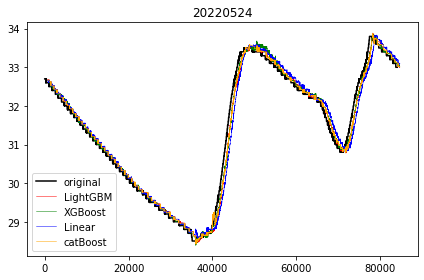

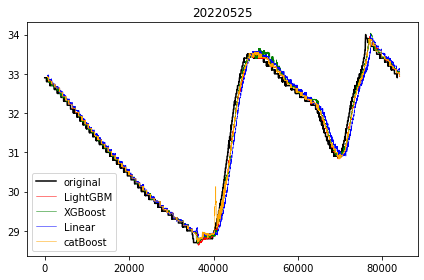

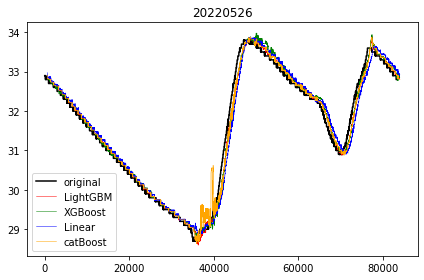

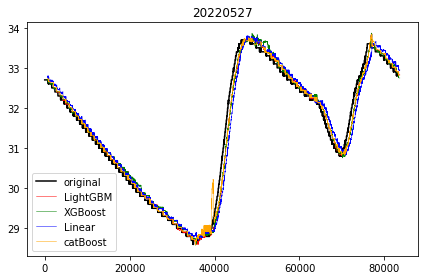

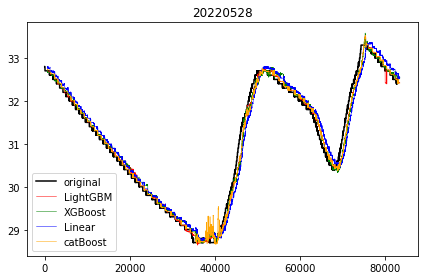

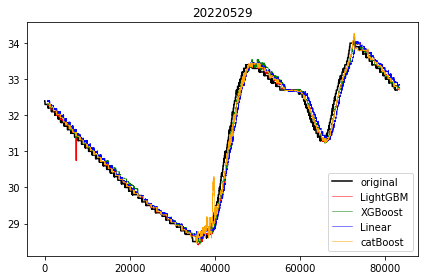

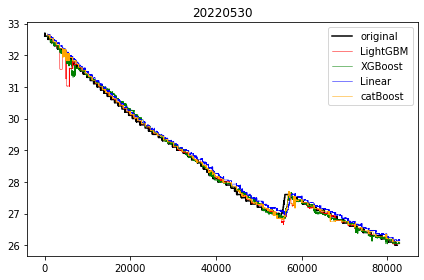

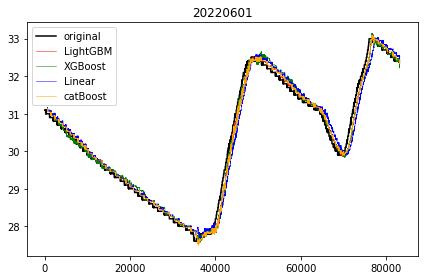

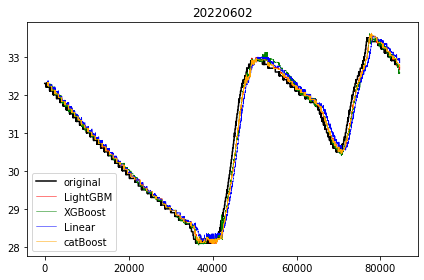

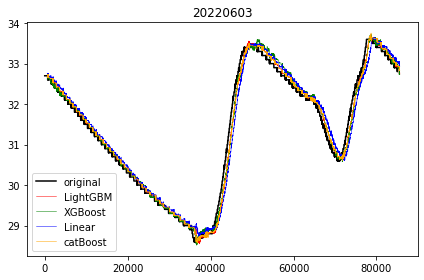

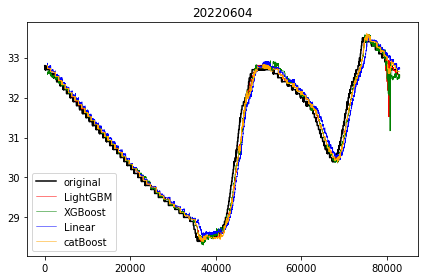

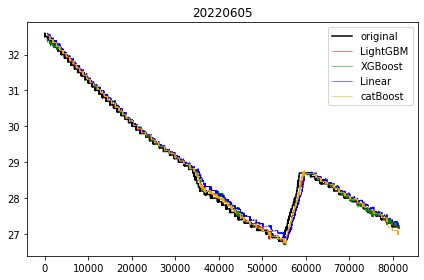

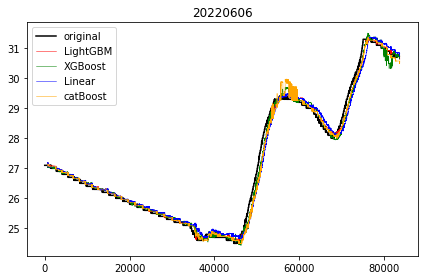

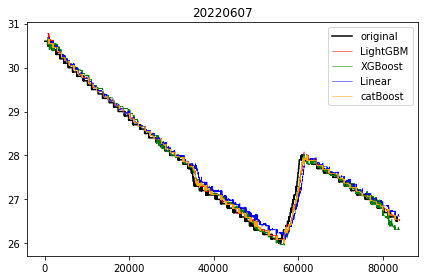

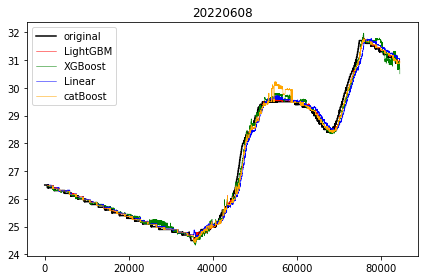

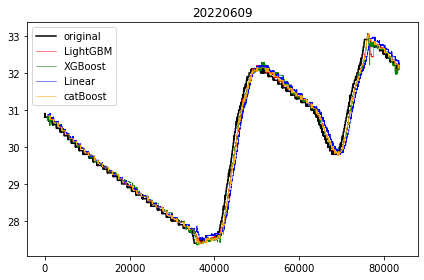

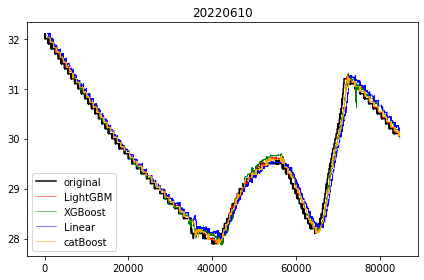

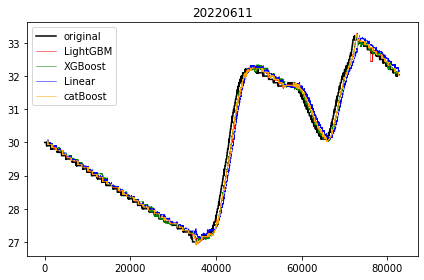

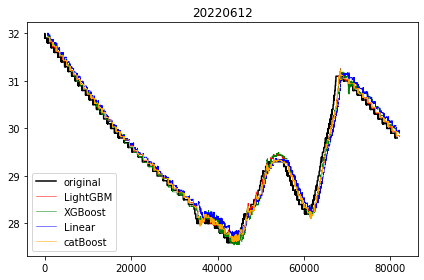

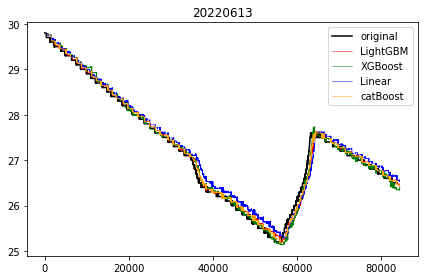

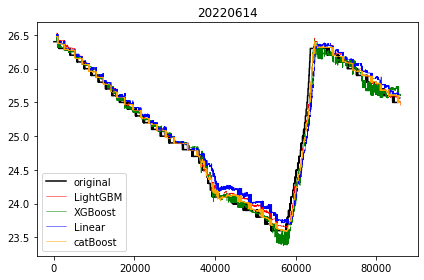

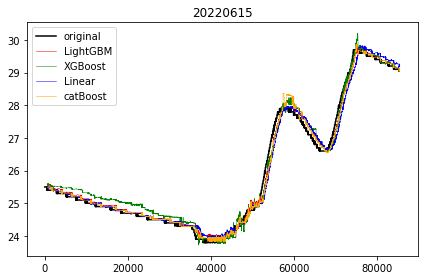

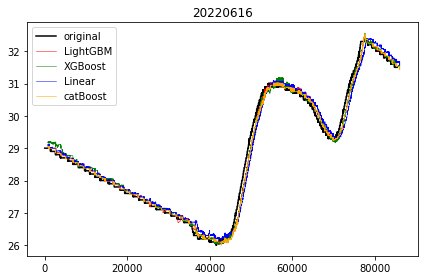

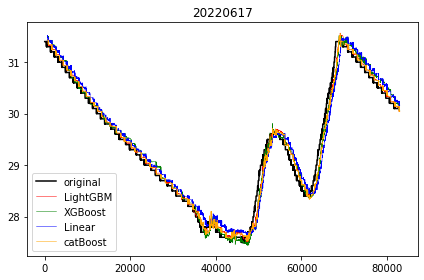

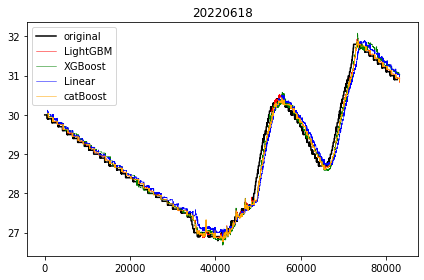

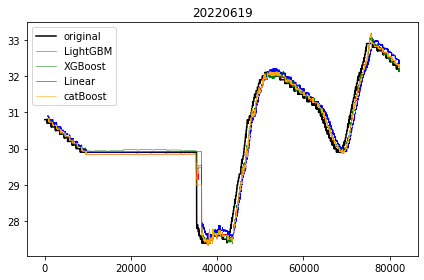

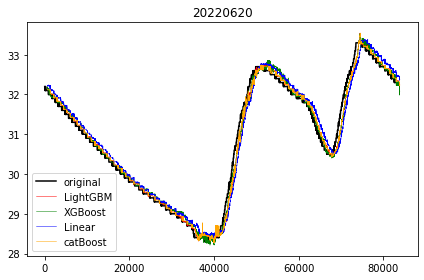

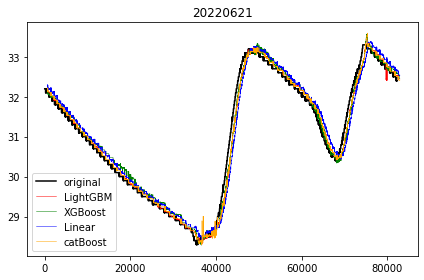

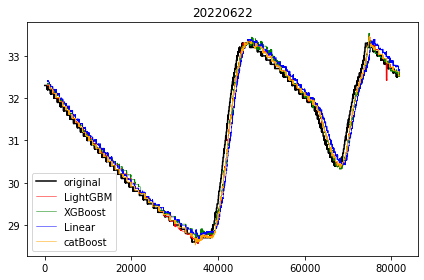

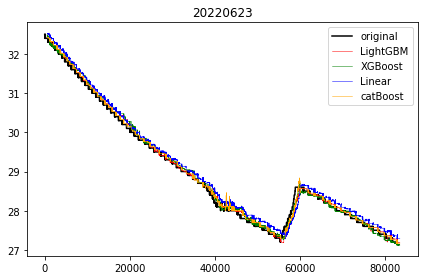

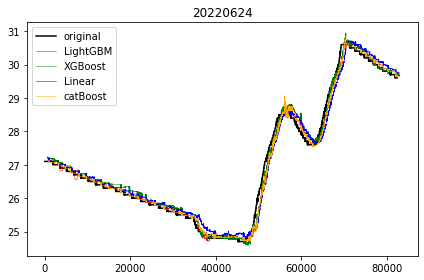

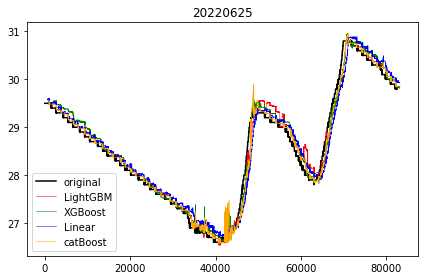

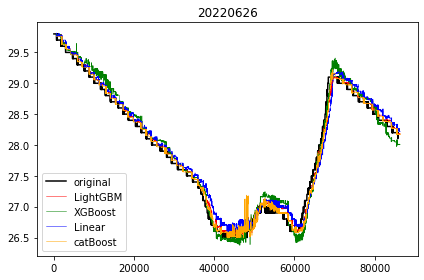

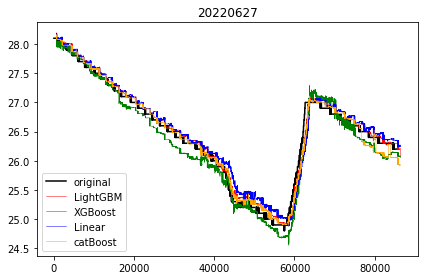

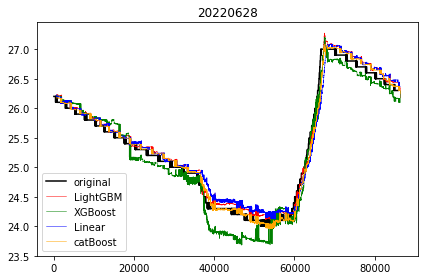

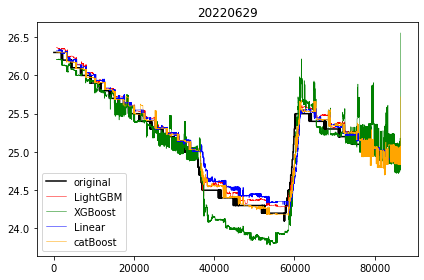

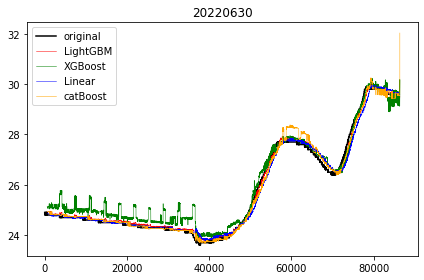

In [9]:
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error


def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

path = "./forecasting_data/"

save_f = "./figure/" + label + "/"

for valid_date in valid_dates:
    try:
        valid = pd.read_feather(path + valid_date + "/rack.feather")[sel_features]

        validX = valid.iloc[:-600,:]
        validY = valid.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

        lgb_pred = lgb_model.predict(validX)
        xgb_pred = xgb_model.predict(validX)
        linear_pred = linear_reg.predict(validX)
        cat_pred = cat_model.predict(validX)
    except:
        continue
    '''
    plt.subplot(2,3,1)
    plt.hist(validY, range=(3.2,4.2), color = 'b', label = 'original')
    
    plt.subplot(2,3,2)
    plt.hist(lgb_pred, range=(3.2,4.2), color = 'orange', label = 'prediction(LightGBM)')
    
    plt.subplot(2,3,3)
    plt.hist(xgb_pred, range=(3.2,4.2), color = 'green', label = 'prediction(XGBoost)')
    
    plt.subplot(2,3,6)
    plt.plot(range(len(validY)),validY, color='black', label = 'original')
    
    
    ax0 = plt.subplot2grid((2, 3), (0, 0), rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((2, 3), (0, 1), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 3), (1, 0), rowspan=1, colspan=3)

    ax0.hist(validY, range=(3.2,4.2), color = 'b', label = 'original')
    ax1.hist(lgb_pred, range=(3.2,4.2), color = 'orange', label = 'LightGBM')
    #ax2.hist(xgb_pred, range=(3.2,4.2), color = 'green', label = 'XGBoost')
    ax2.hist(linear_pred, range=(3.2,4.2), color = 'green', label = 'Linear')
    
    length = len(validY)
    ax3.plot(range(len(validY)),validY, color='black', label = 'original')
    ax3.plot(range(600,length+600), lgb_pred, color = 'orange', label = 'prediction')
    #ax3.plot(range(600,length+600), xgb_pred, color = 'green', label = 'prediction')
    ax3.plot(range(600,length+600), linear_pred, color = 'green', label = 'prediction')
    
    ax0.legend(loc='upper left')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    '''
    length = len(validY)
    
    plt.plot(range(len(validY)),validY, color='black', label = 'original')
    plt.plot(range(600,length+600), lgb_pred, color = 'r', linewidth = 0.5, label = 'LightGBM')
    plt.plot(range(600,length+600), xgb_pred, color = 'g', linewidth = 0.5, label = 'XGBoost')
    plt.plot(range(600,length+600), linear_pred, color = 'b', linewidth = 0.5, label = 'Linear')
    plt.plot(range(600,length+600), cat_pred, color = 'orange', linewidth = 0.5, label = 'catBoost')
    
    plt.legend()
    
    plt.title(valid_date)
    
    plt.tight_layout()
    plt.savefig(save_f+f"{valid_date}.jpg", dpi=600)
    
    plt.show()

In [10]:
import joblib

save_model_path = "./model/" + label + "/"

joblib.dump(lgb_model, save_model_path + "lgb_model.pkl") 
joblib.dump(xgb_model, save_model_path + "xgb_model.pkl") 
joblib.dump(linear_reg, save_model_path + "linear_model.pkl") 
joblib.dump(cat_model, save_model_path + "cat_model.pkl") 

['./model/RACK_MAX_CELL_TEMPERATURE/cat_model.pkl']